In [1]:
from multiprocessing import Pool
import numpy as np
from scipy import optimize
from scipy import sparse
import math

In [14]:
def decode(A, y):
    """Decode y
    
    Parameters
    ----------
    A : np.array
        Encoding matrix
    y : np.array
        Ax + e for some error e
    
    Returns
    -------
    np.array
        Solving the standard LP

        min [ 0 1 ]^T[ g  t ]

        s.t.
        [ -A -I ][ g ] <= [ -y ]
        [  A -I ][ t ]    [  y ]
    """

    A_ub = np.concatenate((
        np.concatenate((A * -1, A), axis=0),
        np.concatenate((
            -1 * np.identity(A.shape[0]),
            -1 * np.identity(A.shape[0])), axis=0)), axis=1)

    b_ub = np.concatenate((-1 * y, y), axis=0)
    lp_coeff = np.concatenate((np.zeros(A.shape[1]), np.ones(A.shape[0])))

    return optimize.linprog(
        lp_coeff, A_ub=A_ub, b_ub=b_ub,
        bounds=[(None, None) for _ in range(A.shape[1])] + [(0, None) for _ in range(A.shape[0])],
        method='simplex',
        options={'tol': 1e-9, 'maxiter': 10000})


In [15]:
def form(n=256, error=0.1, mscale=2):
    """Form test inputs
    
    Parameters
    ----------
    n : int
        Input dimensions
    error : float
        Corruption ratio
    mscale : int
        m as a factor of n (i.e. m=2n <=> mscale=2)
    
    Returns
    -------
    [np.array, np.array, np.array, np.array]
        [A, x, e, y]
    """

    m = mscale * n

    A = np.random.normal(size=(m, n), scale=math.sqrt(1 / n))
    x = np.random.normal(size=(n, 1))
    e = sparse.random(m, 1, density=error).A
    y = np.matmul(A, x) + e

    return A, x, e, y

In [30]:
def test(n, error, mscale, threshold=1e-7):
    """Run a single test
    
    Parameters
    ----------
    n : int
        Input dimensions
    error : float
        Corruption ratio
    mscale : int
        m as a factor of n (i.e. m=2n <=> mscale=2)
    threshold : float
        threshold to consider two values the same
        
    Returns
    -------
    [float, int]
        0: l_0 norm of the error, with errors under ``threshold`` ignored
        1: status code returned by scipy.optimize.linprog
    """

    A, x, e, y = form(n=n, error=error, mscale=mscale)

    opt = decode(A, y)

    error = x[:, 0] - opt.x[:n]
    error[np.abs(error) < threshold] = 0

    err = np.linalg.norm(error, ord=0)
    
    return err, opt.status


def test_mp(args):
    """Procpool compatible wrapper of test"""

    n, error, mscale, threshold = args
    return test(n, error, mscale, threshold)


In [31]:
def profile(n, error, mscale, iterations):
    """Run profile for given parameters
    
    Parameters
    ----------
    n : int
        Input dimensions
    error : float
        Corruption ratio
    mscale : int
        m as a factor of n (i.e. m=2n <=> mscale=2)
    iterations : int
        Number of tests to run
    
    Returns
    -------
    [float, float[], int[]]
        [proportion error, error values, status code of scipy.optimize.linprog]
    """
    
    p = Pool()
    res = p.map(test_mp, [[n, error, mscale, 1e-13] for _ in range(iterations)])

    errors = [r[0] for r in res]
    status = [r[1] for r in res]
    
    perr = len([i for i in errors if i == 0]) / len(errors)

    return perr, errors, status
    

In [24]:
d = []
x = [0.05 * (i + 1) for i in range(8)]
for e in x:
    perr, src, status = profile(128, e, 2, 10)
    d.append(perr)
    print("{:.2f} {} {} {}".format(e, perr, src, status))

0.05 1.0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.10 1.0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.15 1.0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.20 0.8 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128.0, 128.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.25 0.0 [128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.30 0.0 [128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.35 0.0 [128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.40 0.0 [128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
from matplotlib import pyplot as plt

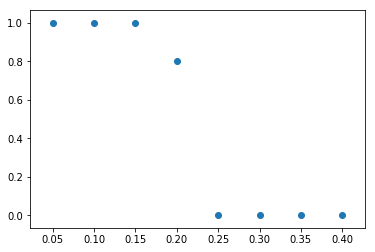

In [28]:
plt.scatter(x, d)